In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.random.set_seed(7)
# np.random.seed(7)
import datetime as dt
from tensorflow.keras.callbacks import EarlyStopping
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
btc_input_df = pd.read_csv("data/FBTC-USD-mar-2017-to-06-feb-2023.csv")

btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2168 non-null   object 
 1   Close           2168 non-null   float64
 2   High            2168 non-null   float64
 3   Low             2168 non-null   float64
 4   Open            2168 non-null   float64
 5   Volume          2168 non-null   float64
 6   n-transactions  2168 non-null   int64  
 7   MKTCP           2168 non-null   float64
 8   HRATE           2168 non-null   float64
 9   DIFF            2168 non-null   float64
 10  AVBLS           2168 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 186.4+ KB


In [6]:
# Convert 'Date' to datetime and set as index (optional)
btc_input_df['Date'] = pd.to_datetime(btc_input_df['Date'])
btc_input_df.set_index('Date', inplace=True)

In [7]:
btc_input_df.head()

,Close,High,Low,Open,Volume,n-transactions,MKTCP,HRATE,DIFF,AVBLS
Date,,,,,,,,,,
2017-03-01,1222.500000,1222.500000,1179.689941,1180.040039,229056992.0,315883,1.989809e+10,3155225.442,4.410000e+11,0.979146
2017-03-02,1251.010010,1262.130005,1215.619995,1224.680054,368275008.0,329428,2.050876e+10,3440072.183,4.410000e+11,0.955612
2017-03-03,1274.989990,1280.310059,1250.709961,1250.709961,315739008.0,337310,2.089075e+10,3458650.323,4.460000e+11,0.985290
2017-03-04,1255.150024,1279.400024,1230.510010,1277.430054,183270000.0,268875,2.051548e+10,3069265.850,4.610000e+11,0.986085
2017-03-05,1267.119995,1267.290039,1238.060059,1254.290039,134127000.0,280739,2.062121e+10,3367030.447,4.610000e+11,0.983301


In [8]:
# Select features
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'n-transactions', 'MKTCP', 'HRATE', 'DIFF', 'AVBLS']
data = btc_input_df[features]

In [9]:
# Handle missing values if any
data = data.dropna()

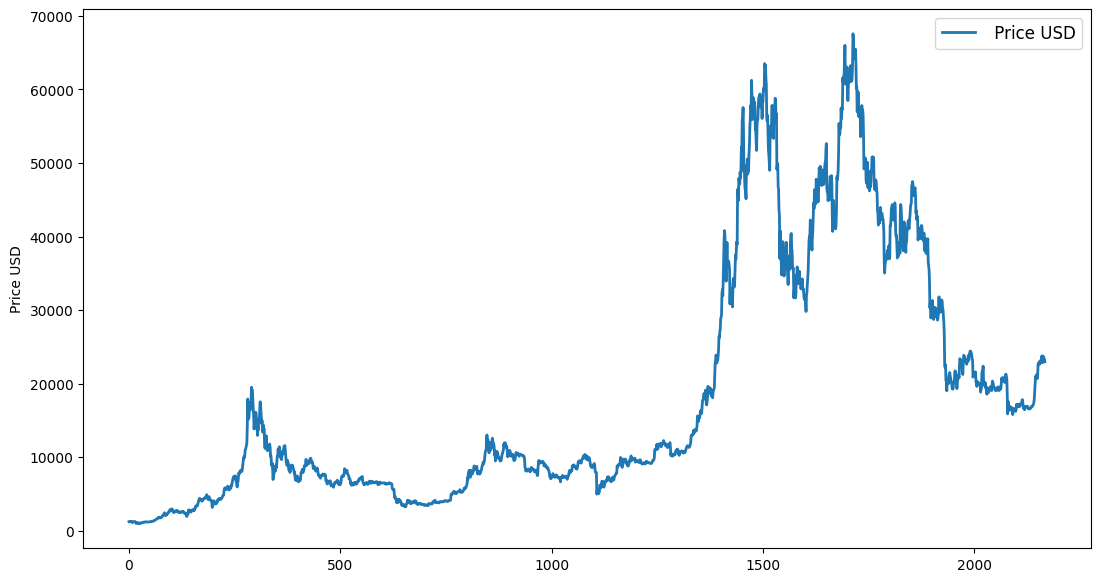

In [8]:
# btc_input_df_datetype.shape
closing_price = data['Close']
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(closing_price, label=' Price USD', linewidth=2)
# ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=10)
ax.set_title('', fontsize=12)
ax.legend(loc='best', fontsize=12)

In [ ]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # 'Close' is the target variable
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("trainX: ", X_train.shape)
print("trainY: ", y_train.shape)
print("testX: ", X_test.shape)
print("testY", y_test.shape)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
#Output Layer
model.add(Dense(units=1))

In [ ]:

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

In [ ]:
# Predicting the prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]


In [ ]:
# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(btc_input_df.index[-len(y_test):], y_test, color='blue', label='Actual Prices')
plt.plot(btc_input_df.index[-len(y_test):], predictions, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

In [ ]:
#Please Note that play around with Hyper-Parameters for better results and good insights..